# This scripts contains two additional tests.
 1. The selection of optimal states
 2. The full correlation between semantic contexts and annotations 

In [1]:
import numpy as np
import nilearn
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker, NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import datasets
import nibabel
import scipy
import re
import pickle
import hmmlearn
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
from datetime import date
import time
import os
import itertools
import argparse
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from utils import *
import pandas as pd
from scipy.stats import ttest_ind, pearsonr
from statannot import add_stat_annotation
import plotly.express as px

#pre defined terms
tmp_dir = "/Users/enningyang/Documents/forrest_project/tmp_data"
c_names_dict = np.load(f"{tmp_dir}/c_names_dict.npy", allow_pickle=True).item()
yeo7_color = np.load(f"{tmp_dir}/yeo7_color.npy", allow_pickle=True).item()
haNames = list(np.load(f"{tmp_dir}/hippoAmygNames.npy"))
hippoNames = haNames[:19]
amygNames = haNames[19:]
annotations = pickle.load(open(f"{tmp_dir}/annotations.pickle", "rb"))
annotations_keys = list(annotations.keys())
n_pcs_dict = {'hippo':6, 'amyg':6}
subjects = np.load(f'{tmp_dir}/subjects.pickle',allow_pickle=1)
save_fig=0

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/enningyang/Documents/forrest_project/hmm_forrest_code/openverison/utils.py:74: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(re.findall(prefix, i)) is not 0


In [2]:
#gather the wanted keys
key = 'final'
filter_words = [key,'subject_01']
filter_words = [key,'Default','subject_01', 'sub_nmf','n200','amyg']
args_list = list(set(np.load(f"{tmp_dir}/hmmlearn_args_list.npy")))

for i in filter_words:
    args_list = filter_args(i, args_list)
if 'final' in args_list[0]:
    args_list = [ i for i in args_list if 'n200_4_states_sub_nmf' in i or 'n5_4_states_sub_pca' in i]
args_list = np.unique(args_list)
args_list = [i.replace('/home/enning/scratch/forrest','/Users/enningyang/Documents/forrest_project') for i in args_list]

In [3]:
#load the models 
state_p_dict = {}
cora_dict = {}
cort_dict = {}
keys_dict = {}
HMMs_dict = {}
idx_dict = {}
errors = []
pls_dict = {}
for i, a in enumerate(args_list):
    tmp = get_args(a, 0, return_idx=0)
    if tmp is None:
        errors.append(a)
        continue
    state_p_dict[a], cora_dict[a], cort_dict[a], HMMs_dict[
        a], ak, tk, X_stack = tmp
    keys_dict[a] = (ak, tk)

In [4]:
#clean up the idx
subset = args_list = list(HMMs_dict.keys())
extra_dict = {
    'hippo': [i for i in args_list if 'hippo' in i],
    'amyg': [i for i in args_list if 'amyg' in i],
}
print(len(args_list))
states = np.unique(np.hstack([re.findall('(\d+)_states',i) for i in args_list]))
region_dict = {key:[i for i in args_list if key in i] for key in yeo7_color.keys()}
states_dict = {key:[i for i in args_list if key in i] for key in states}
sub_dict = {key:[i for i in args_list if 'subject_'+key in i] for key in subjects}
ntext_dict = {key:[i for i in args_list if key in i] for key in ['n200','n5']}

main_compare = args_list[0]
HMM1 = HMMs_dict[main_compare]

1


# Select states


## correlation with semantic contexts

([<matplotlib.axis.XTick at 0x7fc7a9732bb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

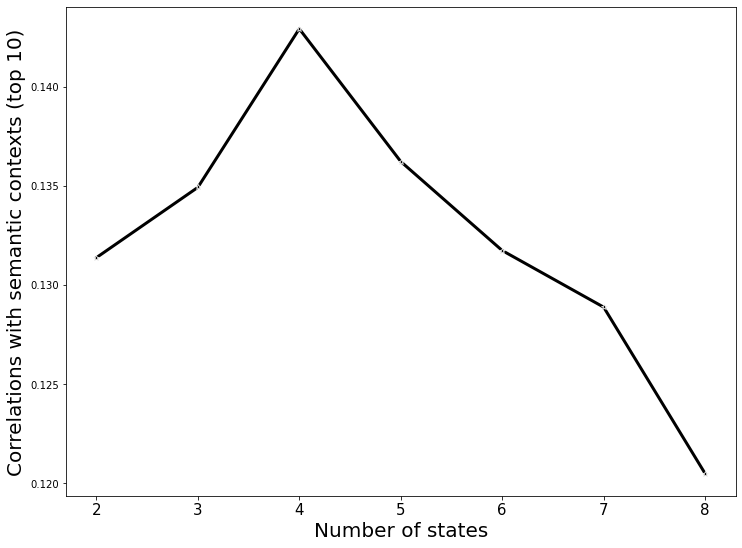

In [15]:
# subtitles
df_all = pd.read_csv(f'{tmp_dir}/n_state_top10_mean.csv')
rst = df_all.groupby(['n_state','net','limbic']).median()
rst.sort_values('n_state')

fig, ax = plt.subplots(figsize=(12, 9))

sns.lineplot(x='n_state',y='index',data=rst,marker='*',ax=ax,ci=None,color='black', linewidth=3)
# sns.lineplot(x='n_state',y='index',hue='net',data=rst,marker='o',ci=None,ax=ax,alpha  = 0.5,color='black')

plt.xlabel('Number of states', fontsize = 20)
plt.ylabel("Correlations with semantic contexts (top 10)",  fontsize = 20)
# plt.title('optimal # sates selection (text type: descriptions)')
plt.xticks([2,3,4,5,6,7,8],fontsize=15)

([<matplotlib.axis.XTick at 0x7fc7a974a280>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

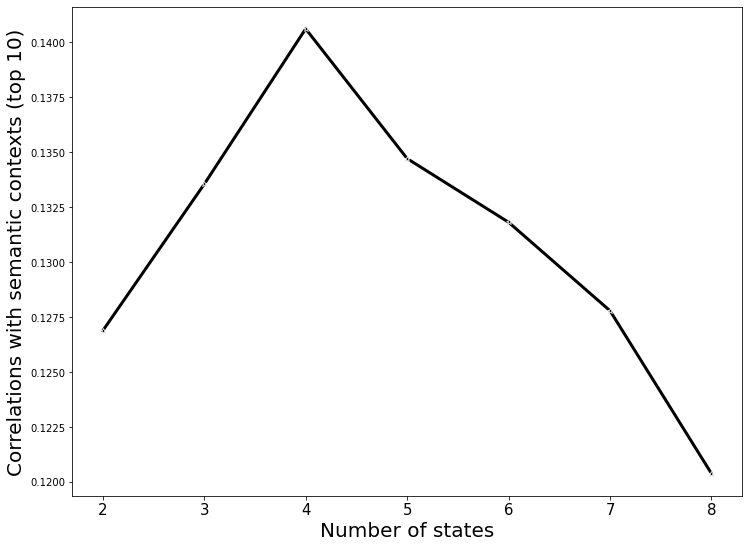

In [16]:
# Descriptions
df_all = pd.read_csv(f'{tmp_dir}/n_state_top10_meanDes.csv')
rst = df_all.groupby(['n_state','net','limbic']).median()
rst.sort_values('n_state')

fig, ax = plt.subplots(figsize=(12, 9))

sns.lineplot(x='n_state',y='index',data=rst,marker='*',ax=ax,ci=None,color='black', linewidth=3)
# sns.lineplot(x='n_state',y='index',hue='net',data=rst,marker='o',ci=None,ax=ax,alpha  = 0.5,color='black')

plt.xlabel('Number of states', fontsize = 20)
plt.ylabel("Correlations with semantic contexts (top 10)",  fontsize = 20)
# plt.title('optimal # sates selection (text type: descriptions)')
plt.xticks([2,3,4,5,6,7,8],fontsize=15)

##  similarities across subjects

([<matplotlib.axis.XTick at 0x7fa743962d90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

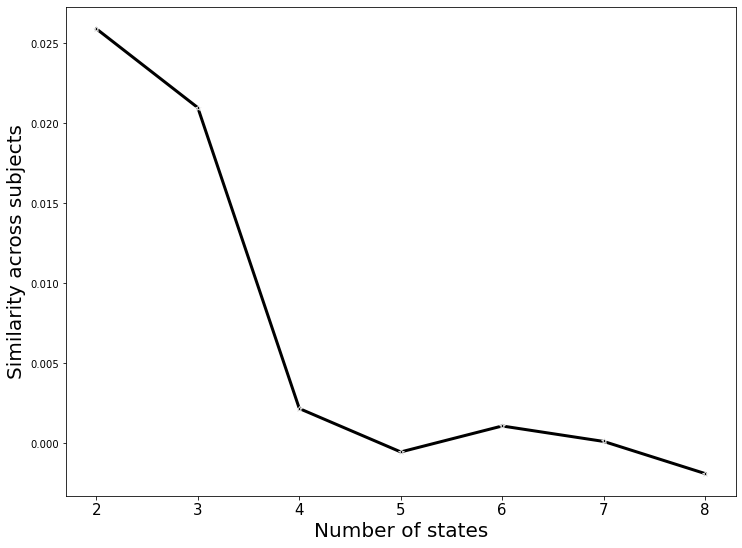

In [34]:
df = pd.read_csv(f'{tmp_dir}/n_state_rho.csv')
df_all =df
rst = df_all.groupby(['n_state']).mean()
rst.sort_values('index')
# rst


fig, ax = plt.subplots(figsize=(12, 9))

sns.lineplot(x='n_state',y='index',data=rst,marker='*',ax=ax,ci=None,color='black', linewidth=3)
# sns.lineplot(x='n_state',y='index',hue='net',data=rst,marker='o',ci=None,ax=ax,alpha  = 0.5,color='black')

plt.xlabel('Number of states',fontsize=20)
plt.ylabel("Similarity across subjects",fontsize=20)
# plt.title('optimal # sates selection (text type: subtitles)')
plt.xticks([2,3,4,5,6,7,8],fontsize=15)

## BIC



In [ ]:
df_all = pd.read_csv(f'{tmp_dir}/n_state_ABIC.csv')
rst = df_all.groupby(['n_state']).median()
rst.sort_values('BIC')
fig, ax = plt.subplots(figsize=(12, 9))

sns.lineplot(x='n_state',y='BIC',data=rst,marker='*',ax=ax,ci=None,color='black', linewidth=3)
# sns.lineplot(x='n_state',y='BIC',hue='net',data=rst,marker='o',ci=None,ax=ax,alpha  = 0.5,color='black')

plt.xlabel('Number of states',fontsize=20)
plt.ylabel("Bayesian information criterion",fontsize=20)
# plt.yscale('log')
# plt.title('optimal # sates selection (text type: subtitles)')
plt.xticks([2,3,4,5,6,7,8],fontsize=15)

([<matplotlib.axis.XTick at 0x7fa770f191c0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

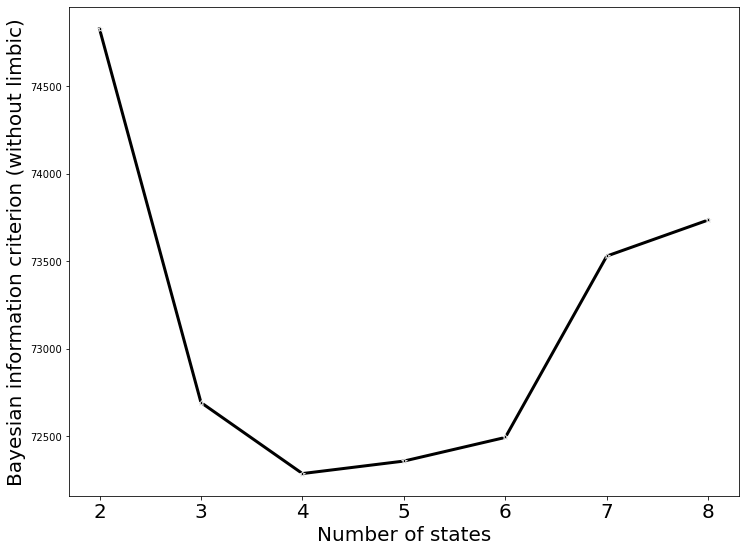

In [38]:
df_all = pd.read_csv(f'{tmp_dir}/n_state_ABIC_wo_limbic.csv')
rst = df_all.groupby(['n_state']).median()
rst.sort_values('BIC')
fig, ax = plt.subplots(figsize=(12, 9))

sns.lineplot(x='n_state',y='BIC',data=rst,marker='*',ax=ax,ci=None,color='black', linewidth=3)
# sns.lineplot(x='n_state',y='BIC',hue='net',data=rst,marker='o',ci=None,ax=ax,alpha  = 0.5,color='black')

plt.xlabel('Number of states', fontsize=20)
plt.ylabel("Bayesian information criterion (without limbic)",fontsize=20)
# plt.yscale('log')
# plt.title('optimal # sates selection (text type: subtitles)')
plt.xticks([2,3,4,5,6,7,8],fontsize=20)

# coralation between 200 semantic contexts and 52 annotaions

<ipython-input-17-bd224802caa8>:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  figs.tight_layout(rect=[0, 0, .9, 1])


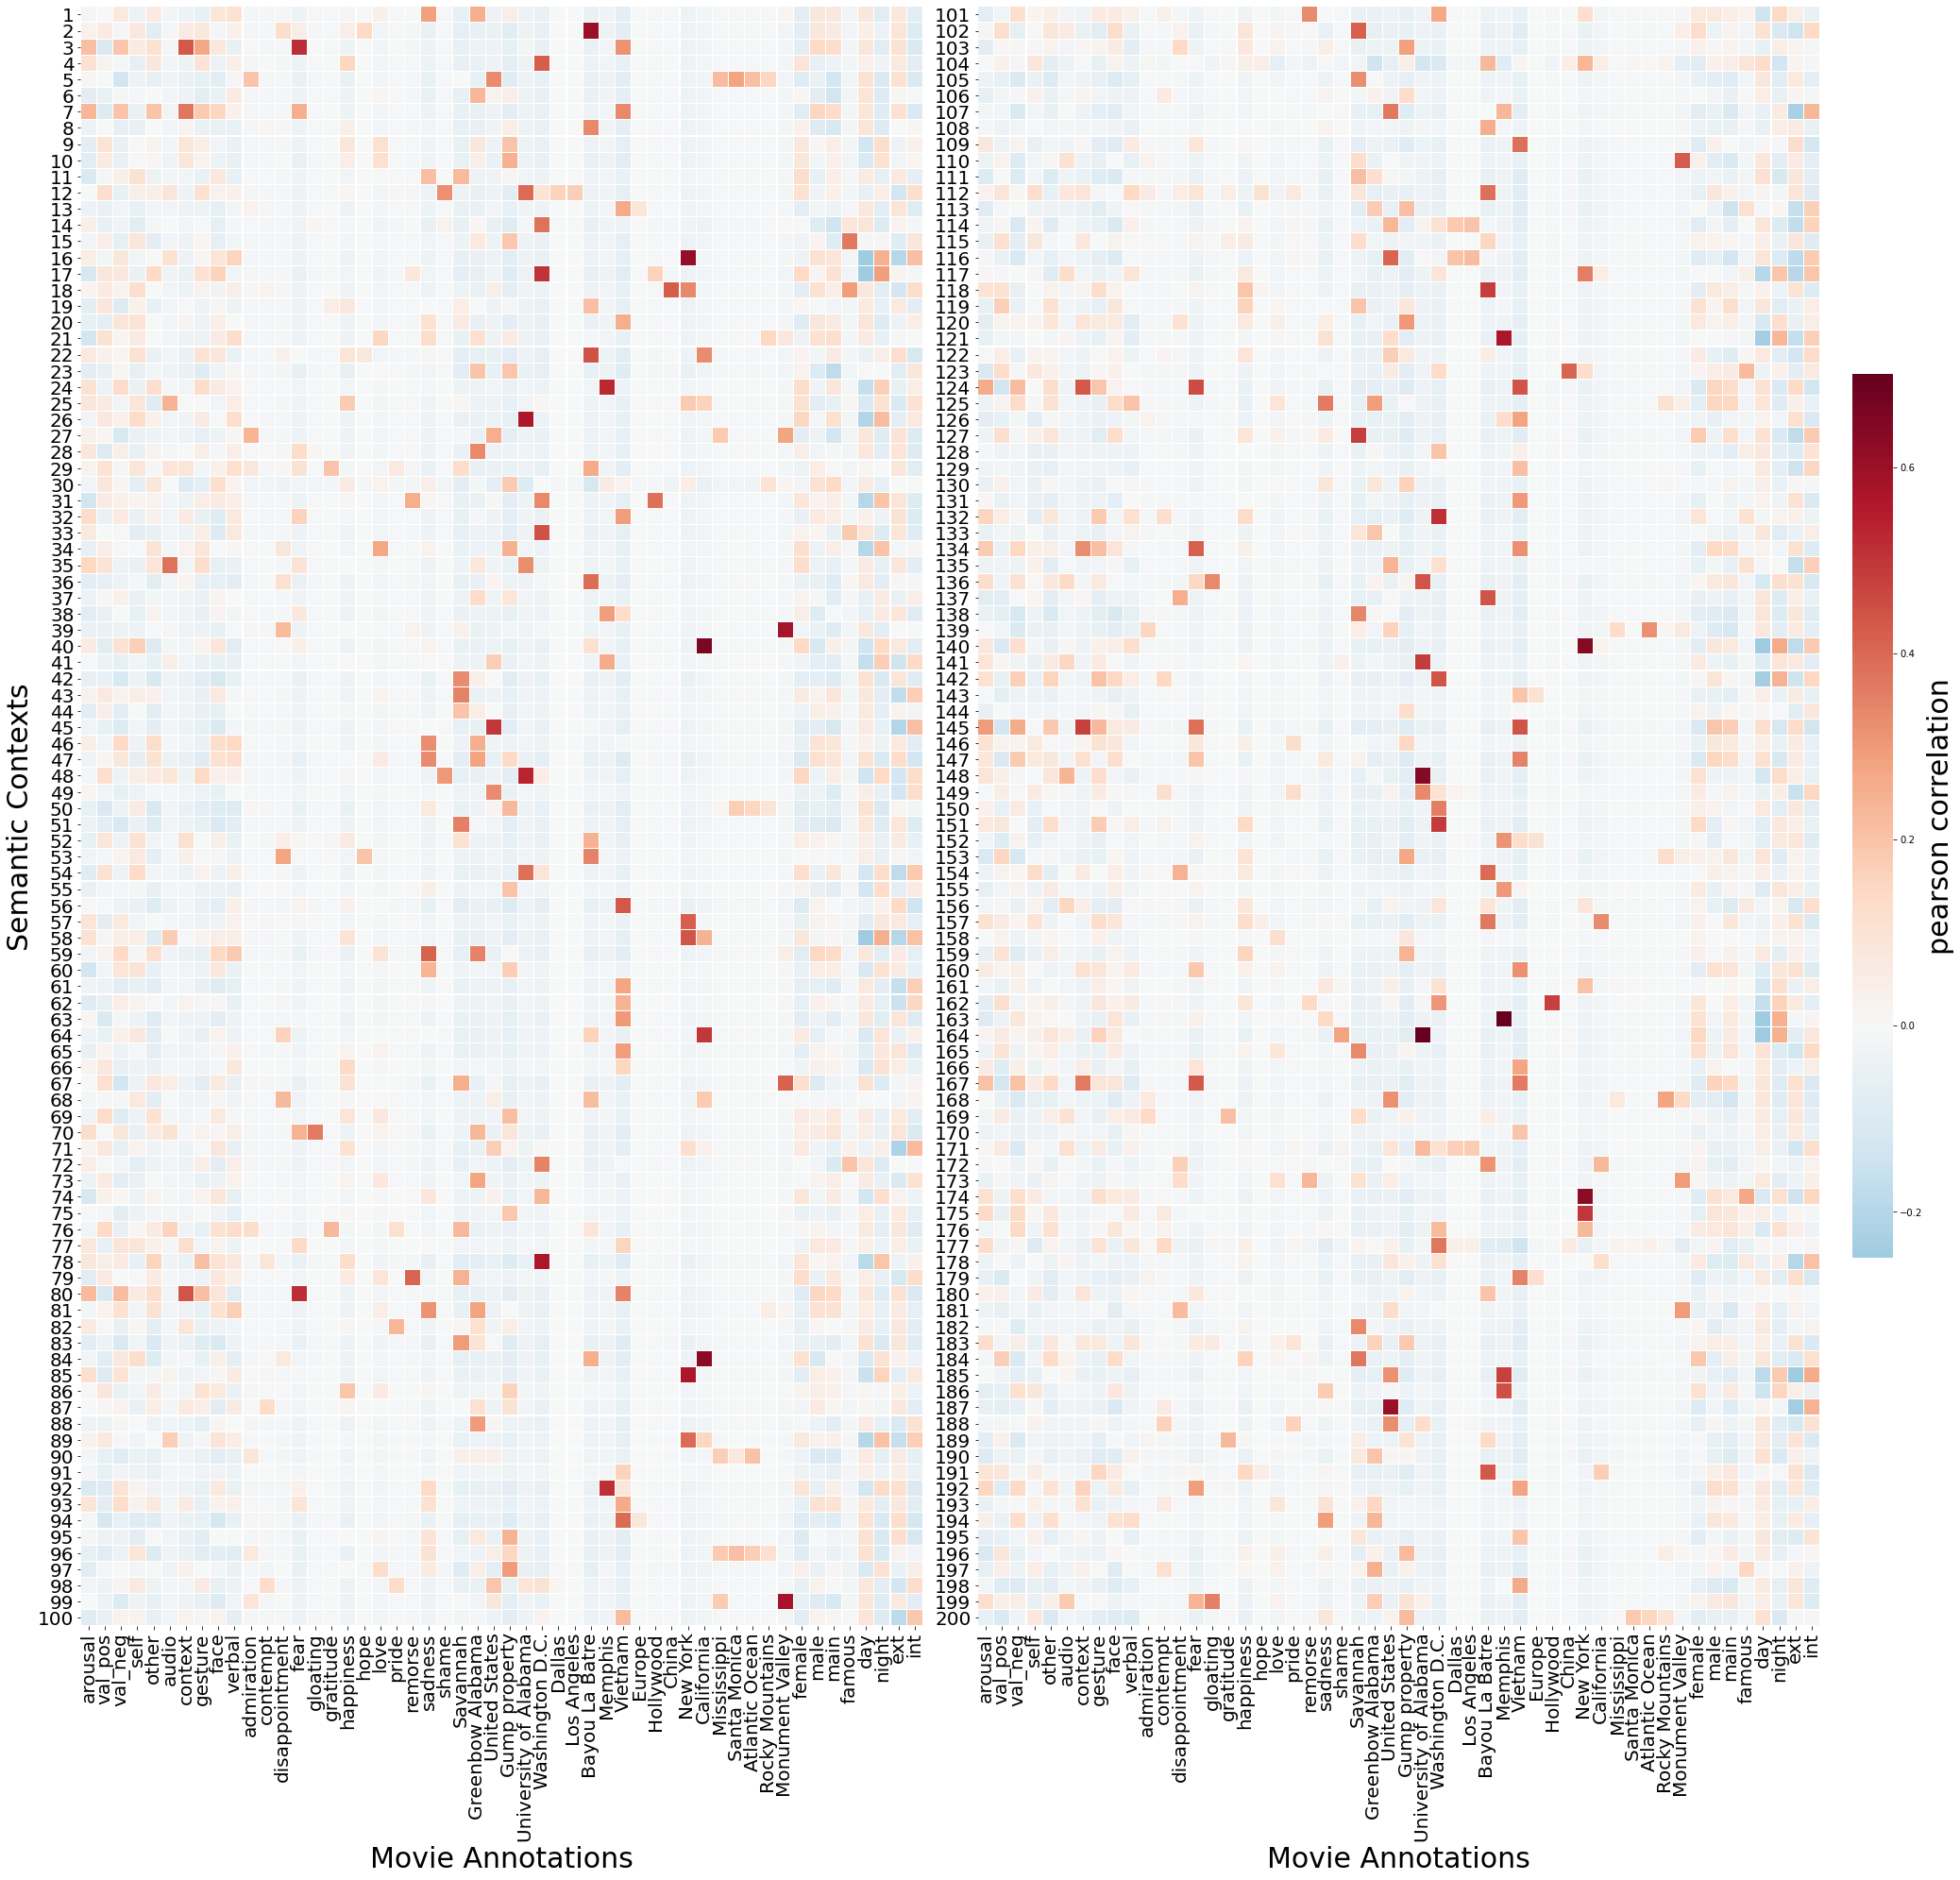

In [17]:
four = np.load(f'{tmp_dir}/lsa_embed_sub_nmf200.npy')
cora = np.zeros([200,52])
for i in range(200):
    for j in range(52):
        cora[i,j] = pearsonr(four[:,i], annotations[annotations_keys[j]])[0]



figs, (ax1,ax2) = plt.subplots(1,2,figsize=(30,65))
cbar_ax = figs.add_axes([.91, .4, .02, .2])
cbar_ax.yaxis.label.set_size(30)

im1 = sns.heatmap(cora[:100,:],cmap='RdBu_r', center = 0, square=True,xticklabels=annotations_keys,yticklabels=range(1,101),
            linewidths=0.1,cbar_kws={'label': 'pearson correlation',"shrink": .22,},vmin=-0.25,vmax=0.7,ax=ax1,cbar_ax=cbar_ax)
ax1.set_ylabel('Semantic Contexts',fontsize=30)
ax1.set_xlabel('Movie Annotations',fontsize=30)
ax1.tick_params(axis='x', rotation=90,labelsize=20)
im1.set_yticklabels(range(1,101),rotation=0,fontsize=20)

im2 = sns.heatmap(cora[100:,:],cmap='RdBu_r', center = 0, square=True,xticklabels=annotations_keys,yticklabels=range(101,201),
            linewidths=0.1,cbar_kws={'label': 'pearson correlation',"shrink": .22},vmin=-0.25,vmax=0.7,ax=ax2,cbar_ax=cbar_ax)
ax2.set_xlabel('Movie Annotations',fontsize=30)
ax2.tick_params(axis='x', rotation=90,labelsize=20)
ax2.tick_params(axis='y', labelsize=20)

figs.tight_layout(rect=[0, 0, .9, 1])

if save_fig:
    plt.savefig(f'/Users/enningyang/Downloads/hmm_figs/sup3_annotationVSsemantic_2col.png',dpi=500,bbox_inches = "tight")

